In [2]:
!python /projects/code/icesat2_boreal/lib/build_tindex_master.py -t Topo -y 2023 -m '06' --user 'montesano' --maap_version master -alg_name 'do_topo_stack_3-1-5'

NASA MAAP is unavailable

Building a list of tiles:
MAAP version:		master
Type:		Topo
Year:		2023
Month:		['06']
Days:		1-31

Output dir:  /projects/my-public-bucket/DPS_tile_lists
                                             s3_path  ...                             file
0  s3://maap-ops-workspace/montesano/dps_output/d...  ...  Copernicus_1_cog_topo_stack.tif

[1 rows x 3 columns]

No duplicates found.

# of duplicate tiles: 0
Final # of tiles: 1
df shape :                                              s3_path  ... tile_num
0  s3://maap-ops-workspace/montesano/dps_output/d...  ...        1

[1 rows x 4 columns]
Writing tindex master csv: /projects/my-public-bucket/DPS_tile_lists/Topo_tindex_master.csv
Building tindex master json and mosaic json...
Traceback (most recent call last):
  File "/projects/code/icesat2_boreal/lib/build_tindex_master.py", line 322, in <module>
    main()
  File "/projects/code/icesat2_boreal/lib/build_tindex_master.py", line 306, in main
    mosaic_json_fn_loc

In [6]:
!pip install -U rio_tiler #rio_cogeo #cogeo_mosaic

  Using cached rio_tiler-5.0.0-py3-none-any.whl (210 kB)
  Attempting uninstall: rio_tiler
    Found existing installation: rio-tiler 4.1.12
    Uninstalling rio-tiler-4.1.12:
      Successfully uninstalled rio-tiler-4.1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cogeo-mosaic 5.1.1 requires morecantile<4.0,>=3.1, but you have morecantile 4.2.0 which is incompatible.
cogeo-mosaic 5.1.1 requires rio-tiler<5.0,>=4.0.0a0, but you have rio-tiler 5.0.0 which is incompatible.


In [1]:
from maap.maap import MAAP
maap = MAAP()

maap._MAAP_HOST

ImportError: cannot import name 'DEPRECATED_SERVICE_NAMES' from 'botocore.docs' (/opt/conda/lib/python3.10/site-packages/botocore/docs/__init__.py)

In [8]:
try:
    from maap.maap import MAAP
    HAS_MAAP = True
except ImportError:
    print('NASA MAAP is unavailable')
    HAS_MAAP = False

NASA MAAP is unavailable


In [71]:
HAS_MAAP

True

In [ ]:
!pip install -U -r /projects/requirements_main.txt

# Launch DPS for 3.1.5_dps.py  
create a topo stack from the Copernicus DEM for each input vector tile


In [7]:
from os import path
import os, glob
import datetime
import pandas as pd
import geopandas as gpd
!pip install xmltodict
import xmltodict
import collections
import sys
sys.path.append('/projects/code/icesat2_boreal/lib')
import ExtractUtils
import contextily as ctx

/tmp/ipykernel_71400/3580300632.py:5: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


NASA MAAP is unavailable


### Register an algorithm
if you recently changed your algorithm (script) [eg. new args, changed tag], then re-register it

In [3]:
maap.register_algorithm_from_yaml_file('/projects/code/icesat2_boreal/dps/alg_3-1-5/do_topo_stack_3-1-5.yml').text

'{"code": 200, "message": {"id": "088905aea4caa11246d1a7577d757df82751c34c", "short_id": "088905ae", "created_at": "2023-06-15T20:05:45.000+00:00", "parent_ids": ["ee60ce645e3d34c28ffc0ce84fe96dc1d4cc924d"], "title": "Registering algorithm: do_topo_stack_3-1-5", "message": "Registering algorithm: do_topo_stack_3-1-5", "author_name": "root", "author_email": "root@eb0671e057d7", "authored_date": "2023-06-15T20:05:45.000+00:00", "committer_name": "root", "committer_email": "root@eb0671e057d7", "committed_date": "2023-06-15T20:05:45.000+00:00", "trailers": {}, "web_url": "https://repo.maap-project.org/root/register-job-hysds-v4/-/commit/088905aea4caa11246d1a7577d757df82751c34c", "stats": {"additions": 2, "deletions": 2, "total": 4}, "status": "created", "project_id": 3, "last_pipeline": {"id": 483, "iid": 35, "project_id": 3, "sha": "088905aea4caa11246d1a7577d757df82751c34c", "ref": "main", "status": "created", "source": "push", "created_at": "2023-06-15T20:05:47.177Z", "updated_at": "2023

### Get all tiles

In [8]:
# Get all boreal tiles
boreal_tile_index_path = '/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg' #shared-buckets/nathanmthomas/boreal_grid_albers90k_gpkg.gpkg
boreal_tile_index = gpd.read_file(boreal_tile_index_path)

bad_tiles = [3540,3634,3728,3823,3916,4004] #Dropping the tiles near antimeridian that reproject poorly.

In [17]:
boreal_tile_index[~boreal_tile_index['tile_num'].isin(bad_tiles)].to_crs(4326).boundary.plot(figsize=(20,4))

<AxesSubplot:>

In [12]:
INPUT_TILE_NUM_LIST = boreal_tile_index.tile_num.to_list()
len(INPUT_TILE_NUM_LIST)

5337

In [30]:
TEST_DPS  = True

if TEST_DPS:
    print('Running DPS on a SUBSET list of input')
    DPS_INPUT_TILE_NUM_LIST = INPUT_TILE_NUM_LIST[1:10] #INPUT_TILE_NUM_LIST[100:]
else:
    print('Running DPS on the FULL list of input')
    DPS_INPUT_TILE_NUM_LIST = INPUT_TILE_NUM_LIST
    
print(f"List length: {len(DPS_INPUT_TILE_NUM_LIST)}")

Running DPS on a SUBSET list of input
List length: 9


# Run a DPS of topo tiles

##### This 'identifier' is a job tag - what i have called is like a run-name

In [ ]:
IDENTIFIER = 'do_topo_stack_3-1-5'

In [ ]:
maap.submitJob(identifier="topo_job_tag_test", 
               algo_id="do_topo_stack_3-1-5",version="master",username="montesano",queue="maap-dps-worker-8gb",in_tile_fn="'https://maap-ops-workspace.s3.amazonaws.com/shared/nathanmthomas/boreal_tiles_v003.gpkg'",topo_tile_fn="'https://maap-ops-workspace.s3.amazonaws.com/shared/nathanmthomas/dem30m_tiles.geojson'",
               in_tile_num="3020",
               tile_buffer_m="120",in_tile_layer="boreal_tiles_v003")

In [31]:
%%time
submit_results_df_list = []
len_input_list = len(DPS_INPUT_TILE_NUM_LIST)
print(f"# of input tiles for DPS: {len_input_list}")

for i, INPUT_TILE_NUM in enumerate(DPS_INPUT_TILE_NUM_LIST):

    DPS_num = i+1
     
    ALGO_ID = 'do_topo_stack_3-1-5'
    USER = 'montesano' #'nathanmthomas'
    WORKER_TYPE = 'maap-dps-worker-8gb'
    
    in_param_dict = {
                         'in_tile_fn': 'https://maap-ops-workspace.s3.amazonaws.com/shared/nathanmthomas/boreal_tiles_v003.gpkg',
                         'in_tile_num': INPUT_TILE_NUM,
                         'tile_buffer_m': 120,
                         'in_tile_layer': 'boreal_tiles_v003',
                         'topo_tile_fn': 'https://maap-ops-workspace.s3.amazonaws.com/shared/nathanmthomas/dem30m_tiles.geojson',
        }

    submit_result = maap.submitJob(
            identifier=IDENTIFIER,
            algo_id=ALGO_ID,
            version='master',
            username=USER, # username needs to be the same as whoever created the workspace
            queue=WORKER_TYPE,
            **in_param_dict
        )
    
    # # Build a dataframe of submission details
    # submit_result['dps_num'] = DPS_num
    # submit_result['tile_num'] = INPUT_TILE_NUM
    # submit_result['submit_time'] = datetime.datetime.now()
    # submit_result['dbs_job_hour'] =datetime.datetime.now().hour
    # submit_result['algo_id'] = ALGO_ID
    # submit_result['user'] = USER
    # submit_result['worker_type'] = WORKER_TYPE
    
    # Append to a list of data frames of submission results
    #submit_results_df_list.append(pd.DataFrame([submit_result]))
    submit_results_df_list.append([submit_result]))
    
    if DPS_num in [1, 100, 500, 1000, 1500, 2000, 3000, 5000, 7000, 9000, 11000, 13000, 15000, 17000, 19000, 21000, 24000, len_input_list]:
        print(f"DPS run #: {DPS_num}\t| tile num: {INPUT_TILE_NUM}\t| submit status: {submit_result['status']}\t| job id: {submit_result['job_id']}") 
        
# Build a final submission results df and save
submit_results_df = pd.concat(submit_results_df_list)
nowtime = pd.Timestamp.now().strftime('%Y%m%d%H%M')
print(f"Current time:\t{nowtime}")
submit_results_df.to_csv(f'/projects/my-public-bucket/dps_submission_results/DPS_{IDENTIFIER}_submission_results_{len_input_list}_{nowtime}.csv')
submit_results_df

# of input tiles for DPS: 9


TypeError: 'DPSJob' object is not subscriptable

In [37]:
pd.DataFrame.from_dict(submit_result)

ValueError: DataFrame constructor not properly called!

After almost any DPS job, you have to assess what succeeded and failed. This involves:
1. building a table of job status based on job ids captured in the job_results_df from the DPS run chunk --> this tells you how many jobs failed
2. merging the job status table with the job results df --> this tells you which specific granules (or tile nums) failed
3. building another input list of granules for a follow-up DPS
## Assess DPS results
Build a table of job status based on job id - how many jobs failed?

In [21]:
%%time
fails_list = []
success_list = []
LIST_SUBMISSIONS = sorted(glob.glob(f'/projects/my-public-bucket/dps_submission_results/DPS_{IDENTIFIER}_submission_results_*.csv'),key=ExtractUtils.func, reverse=True)
for DPS_DATETIME in [nowtime]:
    for fn in LIST_SUBMISSIONS:
        if DPS_DATETIME in fn and not 'job_status' in fn:
            DPS_alg_id = os.path.basename(fn.split('_submission_results_')[0].replace('DPS_',''))
            thentime = fn.split('_')[-1].replace('.csv','')
            print(f'DPS alg:\t\t{DPS_alg_id}')
            print(f'DPS launch time:\t{thentime}')
            z = ExtractUtils.BUILD_TABLE_JOBSTATUS(pd.read_csv(fn))
            # Save job status table
            z.to_csv(f'/projects/my-public-bucket/dps_submission_results/DPS_{IDENTIFIER}_submission_results_job_status_{len(z)}_{thentime}.csv')
            
            # Get current fails df and append to list
            #z['run_type'] = DICT_RUN_NAME
            fails_list.append(z[ (z['wps:Status'] != 'Succeeded') & (z['wps:Status'] != 'Running') ] )
            success_list.append(z[ (z['wps:Status'] == 'Succeeded') ] )
            
df_all_fails = pd.concat(fails_list)
df_all_success = pd.concat(success_list)

DPS alg:		do_topo_stack_3-1-5
DPS launch time:	202306151304
Count total jobs:	10
Count pending jobs:	0
Count running jobs:	0
Count succeeded jobs:	6
Count failed jobs:	4
% of failed jobs:	40.0

CPU times: user 274 ms, sys: 3.68 ms, total: 278 ms
Wall time: 804 ms


In [38]:
FAILS_LIST = df_all_fails.tile_num.to_list()
FAILS_LIST

[2, 3, 7, 8]

In [26]:
import matplotlib.pyplot as plt

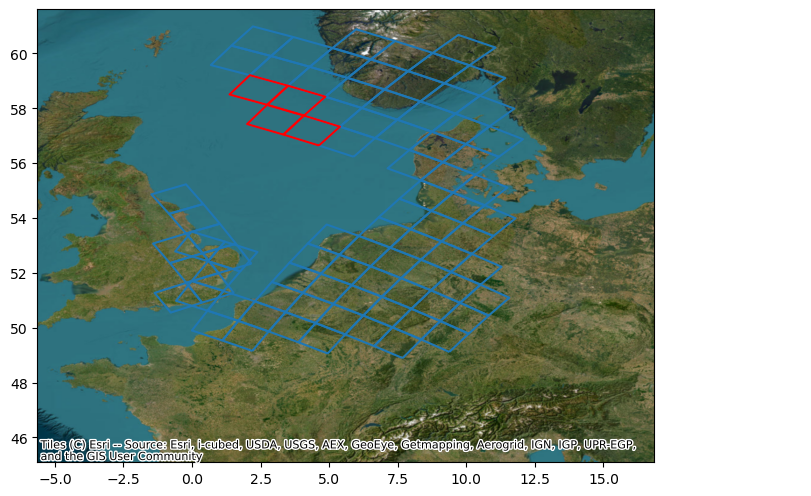

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=1, dpi=100, figsize=(20,6)) 

tmp_df = boreal_tile_index[~boreal_tile_index['tile_num'].isin(bad_tiles)]
ax = tmp_df.to_crs(4326).cx[0:10, 50:60].boundary.plot(ax=ax, figsize=(20,4))
ax = tmp_df[tmp_df['tile_num'].isin(FAILS_LIST)].to_crs(4326).boundary.plot(ax=ax, figsize=(20,4), color='red')

ax = ctx.add_basemap(ax, crs=4326, reset_extent=False, #zoom = ,
                source = ctx.providers.Esri.WorldImagery#GrayCanvas
            )



In [67]:
ALGO_ID

'do_topo_stack_3-1-5'

In [44]:
user = 'p'
if user is None: user = 'nathanmthomas'
print(user)

p


In [2]:
!python /projects/code/icesat2_boreal/lib/build_tindex_master.py -t Topo -y 2023 -m '06' --user 'montesano' --maap_version master -alg_name 'do_topo_stack_3-1-5'

NASA MAAP is unavailable

Building a list of tiles:
MAAP version:		master
Type:		Topo
Year:		2023
Month:		['06']
Days:		1-31

Output dir:  /projects/my-public-bucket/DPS_tile_lists
                                             s3_path  ...                             file
0  s3://maap-ops-workspace/montesano/dps_output/d...  ...  Copernicus_1_cog_topo_stack.tif

[1 rows x 3 columns]

No duplicates found.

# of duplicate tiles: 0
Final # of tiles: 1
df shape :                                              s3_path  ... tile_num
0  s3://maap-ops-workspace/montesano/dps_output/d...  ...        1

[1 rows x 4 columns]
Writing tindex master csv: /projects/my-public-bucket/DPS_tile_lists/Topo_tindex_master.csv
Building tindex master json and mosaic json...
Traceback (most recent call last):
  File "/projects/code/icesat2_boreal/lib/build_tindex_master.py", line 322, in <module>
    main()
  File "/projects/code/icesat2_boreal/lib/build_tindex_master.py", line 306, in main
    mosaic_json_fn_loc

In [6]:
!pip install -U rio_tiler #rio_cogeo #cogeo_mosaic

  Using cached rio_tiler-5.0.0-py3-none-any.whl (210 kB)
  Attempting uninstall: rio_tiler
    Found existing installation: rio-tiler 4.1.12
    Uninstalling rio-tiler-4.1.12:
      Successfully uninstalled rio-tiler-4.1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cogeo-mosaic 5.1.1 requires morecantile<4.0,>=3.1, but you have morecantile 4.2.0 which is incompatible.
cogeo-mosaic 5.1.1 requires rio-tiler<5.0,>=4.0.0a0, but you have rio-tiler 5.0.0 which is incompatible.


In [1]:
from maap.maap import MAAP
maap = MAAP()

maap._MAAP_HOST

ImportError: cannot import name 'DEPRECATED_SERVICE_NAMES' from 'botocore.docs' (/opt/conda/lib/python3.10/site-packages/botocore/docs/__init__.py)

In [70]:
try:
    from maap.maap import MAAP
    HAS_MAAP = True
except ImportError:
    print('NASA MAAP is unavailable')
    HAS_MAAP = False

In [71]:
HAS_MAAP

True

In [ ]:
!pip install -U -r /projects/requirements_main.txt

# Launch DPS for 3.1.5_dps.py  
create a topo stack from the Copernicus DEM for each input vector tile


In [59]:
from os import path
import os, glob
import datetime
import pandas as pd
import geopandas as gpd
!pip install xmltodict
import xmltodict
import collections
import sys
sys.path.append('/projects/code/icesat2_boreal/lib')
import ExtractUtils
import contextily as ctx

### Register an algorithm
if you recently changed your algorithm (script) [eg. new args, changed tag], then re-register it

In [3]:
maap.register_algorithm_from_yaml_file('/projects/code/icesat2_boreal/dps/alg_3-1-5/do_topo_stack_3-1-5.yml').text

'{"code": 200, "message": {"id": "088905aea4caa11246d1a7577d757df82751c34c", "short_id": "088905ae", "created_at": "2023-06-15T20:05:45.000+00:00", "parent_ids": ["ee60ce645e3d34c28ffc0ce84fe96dc1d4cc924d"], "title": "Registering algorithm: do_topo_stack_3-1-5", "message": "Registering algorithm: do_topo_stack_3-1-5", "author_name": "root", "author_email": "root@eb0671e057d7", "authored_date": "2023-06-15T20:05:45.000+00:00", "committer_name": "root", "committer_email": "root@eb0671e057d7", "committed_date": "2023-06-15T20:05:45.000+00:00", "trailers": {}, "web_url": "https://repo.maap-project.org/root/register-job-hysds-v4/-/commit/088905aea4caa11246d1a7577d757df82751c34c", "stats": {"additions": 2, "deletions": 2, "total": 4}, "status": "created", "project_id": 3, "last_pipeline": {"id": 483, "iid": 35, "project_id": 3, "sha": "088905aea4caa11246d1a7577d757df82751c34c", "ref": "main", "status": "created", "source": "push", "created_at": "2023-06-15T20:05:47.177Z", "updated_at": "2023

### Get all tiles

In [8]:
# Get all boreal tiles
boreal_tile_index_path = '/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg' #shared-buckets/nathanmthomas/boreal_grid_albers90k_gpkg.gpkg
boreal_tile_index = gpd.read_file(boreal_tile_index_path)

bad_tiles = [3540,3634,3728,3823,3916,4004] #Dropping the tiles near antimeridian that reproject poorly.

In [17]:
boreal_tile_index[~boreal_tile_index['tile_num'].isin(bad_tiles)].to_crs(4326).boundary.plot(figsize=(20,4))

<AxesSubplot:>

In [12]:
INPUT_TILE_NUM_LIST = boreal_tile_index.tile_num.to_list()
len(INPUT_TILE_NUM_LIST)

5337

In [30]:
TEST_DPS  = True

if TEST_DPS:
    print('Running DPS on a SUBSET list of input')
    DPS_INPUT_TILE_NUM_LIST = INPUT_TILE_NUM_LIST[1:10] #INPUT_TILE_NUM_LIST[100:]
else:
    print('Running DPS on the FULL list of input')
    DPS_INPUT_TILE_NUM_LIST = INPUT_TILE_NUM_LIST
    
print(f"List length: {len(DPS_INPUT_TILE_NUM_LIST)}")

Running DPS on a SUBSET list of input
List length: 9


# Run a DPS of topo tiles

In [31]:
%%time
submit_results_df_list = []
len_input_list = len(DPS_INPUT_TILE_NUM_LIST)
print(f"# of input tiles for DPS: {len_input_list}")

for i, INPUT_TILE_NUM in enumerate(DPS_INPUT_TILE_NUM_LIST):

    DPS_num = i+1
    IDENTIFIER = 'do_topo_stack_3-1-5' 
    ALGO_ID = f'{IDENTIFIER}'
    USER = 'montesano' #'nathanmthomas'
    WORKER_TYPE = 'maap-dps-worker-8gb'
    
    in_param_dict = {
                         'in_tile_fn': 'https://maap-ops-workspace.s3.amazonaws.com/shared/nathanmthomas/boreal_tiles_v003.gpkg',
                         'in_tile_num': INPUT_TILE_NUM,
                         'tile_buffer_m': 120,
                         'in_tile_layer': 'boreal_tiles_v003',
                         'topo_tile_fn': 'https://maap-ops-workspace.s3.amazonaws.com/shared/nathanmthomas/dem30m_tiles.geojson',
        }

    submit_result = maap.submitJob(
            identifier=IDENTIFIER,
            algo_id=ALGO_ID,
            version='master',
            username=USER, # username needs to be the same as whoever created the workspace
            queue=WORKER_TYPE,
            **in_param_dict
        )
    
    # # Build a dataframe of submission details
    # submit_result['dps_num'] = DPS_num
    # submit_result['tile_num'] = INPUT_TILE_NUM
    # submit_result['submit_time'] = datetime.datetime.now()
    # submit_result['dbs_job_hour'] =datetime.datetime.now().hour
    # submit_result['algo_id'] = ALGO_ID
    # submit_result['user'] = USER
    # submit_result['worker_type'] = WORKER_TYPE
    
    # Append to a list of data frames of submission results
    #submit_results_df_list.append(pd.DataFrame([submit_result]))
    submit_results_df_list.append([submit_result]))
    
    if DPS_num in [1, 100, 500, 1000, 1500, 2000, 3000, 5000, 7000, 9000, 11000, 13000, 15000, 17000, 19000, 21000, 24000, len_input_list]:
        print(f"DPS run #: {DPS_num}\t| tile num: {INPUT_TILE_NUM}\t| submit status: {submit_result['status']}\t| job id: {submit_result['job_id']}") 
        
# Build a final submission results df and save
submit_results_df = pd.concat(submit_results_df_list)
nowtime = pd.Timestamp.now().strftime('%Y%m%d%H%M')
print(f"Current time:\t{nowtime}")
submit_results_df.to_csv(f'/projects/my-public-bucket/dps_submission_results/DPS_{IDENTIFIER}_submission_results_{len_input_list}_{nowtime}.csv')
submit_results_df

# of input tiles for DPS: 9


TypeError: 'DPSJob' object is not subscriptable

In [37]:
pd.DataFrame.from_dict(submit_result)

ValueError: DataFrame constructor not properly called!

After almost any DPS job, you have to assess what succeeded and failed. This involves:
1. building a table of job status based on job ids captured in the job_results_df from the DPS run chunk --> this tells you how many jobs failed
2. merging the job status table with the job results df --> this tells you which specific granules (or tile nums) failed
3. building another input list of granules for a follow-up DPS
## Assess DPS results
Build a table of job status based on job id - how many jobs failed?

In [21]:
%%time
fails_list = []
success_list = []
LIST_SUBMISSIONS = sorted(glob.glob(f'/projects/my-public-bucket/dps_submission_results/DPS_{IDENTIFIER}_submission_results_*.csv'),key=ExtractUtils.func, reverse=True)
for DPS_DATETIME in [nowtime]:
    for fn in LIST_SUBMISSIONS:
        if DPS_DATETIME in fn and not 'job_status' in fn:
            DPS_alg_id = os.path.basename(fn.split('_submission_results_')[0].replace('DPS_',''))
            thentime = fn.split('_')[-1].replace('.csv','')
            print(f'DPS alg:\t\t{DPS_alg_id}')
            print(f'DPS launch time:\t{thentime}')
            z = ExtractUtils.BUILD_TABLE_JOBSTATUS(pd.read_csv(fn))
            # Save job status table
            z.to_csv(f'/projects/my-public-bucket/dps_submission_results/DPS_{IDENTIFIER}_submission_results_job_status_{len(z)}_{thentime}.csv')
            
            # Get current fails df and append to list
            #z['run_type'] = DICT_RUN_NAME
            fails_list.append(z[ (z['wps:Status'] != 'Succeeded') & (z['wps:Status'] != 'Running') ] )
            success_list.append(z[ (z['wps:Status'] == 'Succeeded') ] )
            
df_all_fails = pd.concat(fails_list)
df_all_success = pd.concat(success_list)

DPS alg:		do_topo_stack_3-1-5
DPS launch time:	202306151304
Count total jobs:	10
Count pending jobs:	0
Count running jobs:	0
Count succeeded jobs:	6
Count failed jobs:	4
% of failed jobs:	40.0

CPU times: user 274 ms, sys: 3.68 ms, total: 278 ms
Wall time: 804 ms


In [38]:
FAILS_LIST = df_all_fails.tile_num.to_list()
FAILS_LIST

[2, 3, 7, 8]

In [26]:
import matplotlib.pyplot as plt

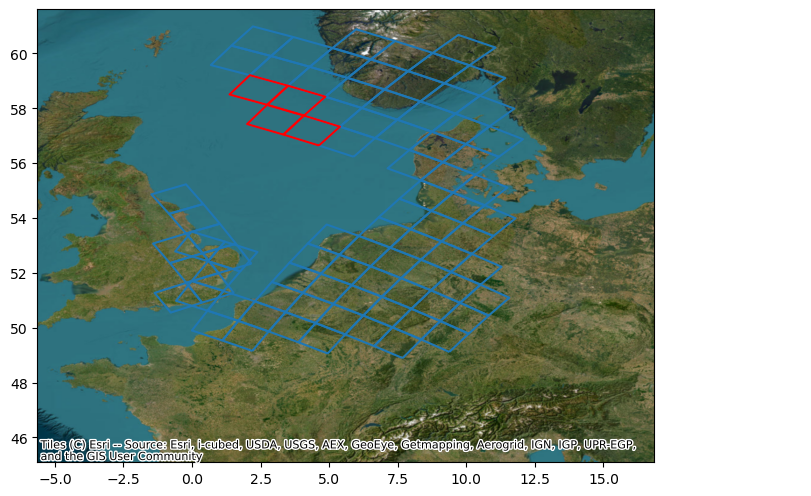

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=1, dpi=100, figsize=(20,6)) 

tmp_df = boreal_tile_index[~boreal_tile_index['tile_num'].isin(bad_tiles)]
ax = tmp_df.to_crs(4326).cx[0:10, 50:60].boundary.plot(ax=ax, figsize=(20,4))
ax = tmp_df[tmp_df['tile_num'].isin(FAILS_LIST)].to_crs(4326).boundary.plot(ax=ax, figsize=(20,4), color='red')

ax = ctx.add_basemap(ax, crs=4326, reset_extent=False, #zoom = ,
                source = ctx.providers.Esri.WorldImagery#GrayCanvas
            )



In [67]:
ALGO_ID

'do_topo_stack_3-1-5'

In [44]:
user = 'p'
if user is None: user = 'nathanmthomas'
print(user)

p
